In [1]:
import h5py
from torchaudio.datasets import LJSPEECH, LIBRISPEECH

In [ ]:
dataset = LIBRISPEECH('../../datasets', download=True, url='train-clean-100')

In [3]:
from tqdm.notebook import tqdm

with h5py.File('../../datasets/lj.h5', 'w') as f:
    for idx, item in tqdm(enumerate(dataset), total=len(dataset)):
        group = f.create_group(str(idx))
        group.create_dataset('wav', data=item[0].numpy()[0], dtype='f4', compression='gzip')
        str_ds = group.create_dataset('text', data=item[3], dtype=h5py.string_dtype())


In [ ]:
f = h5py.File('../../datasets/lj.h5', 'r')

In [ ]:
f['1']['text'].asstr()[()]

In [2]:
import torch
import math

def CosineWithWarmup(
        optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

In [9]:
m = torch.nn.Linear(23, 23)
opt = torch.optim.Adam(m.parameters(), lr=0.01)
p = CosineWithWarmup(opt, 100, 300)

In [10]:
lrs = []

for i in range(300):
    lrs.append(p.get_last_lr()[0])
    p.step()

/Users/mihailkim/miniforge3/envs/dla/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

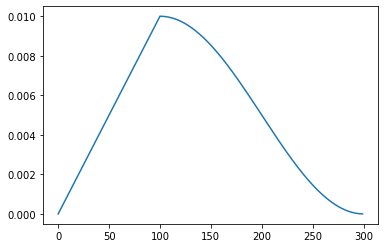

In [13]:
plt.plot(range(300), lrs)